# Emotion Detection Model with Improvements

In [1]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense, Dropout, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

2025-04-16 12:05:34.920113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-16 12:05:34.920228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-16 12:05:35.061725: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Step 1: Data Augmentation

In [2]:
def augment_audio(y, sr):
    augmented_data = []
    augmented_data.append(y)  # Original audio
    try:
        augmented_data.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=2))
        augmented_data.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2))
    except Exception as e:
        print(f"Error applying pitch shift: {e}")
    augmented_data.append(librosa.effects.time_stretch(y, rate=1.2))
    augmented_data.append(librosa.effects.time_stretch(y, rate=0.8))
    noise = np.random.normal(0, 0.005, y.shape)
    augmented_data.append(y + noise)
    return augmented_data

## Step 2: Feature Extraction

In [3]:
def extract_mfcc_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    if len(y) < 2048:  # Skip files that are too short
        print(f"Skipping short file: {file_path}")
        return []
    augmented_audios = augment_audio(y, sr)
    features = []
    for audio in augmented_audios:
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        delta = librosa.feature.delta(mfcc)
        delta_delta = librosa.feature.delta(mfcc, order=2)
        features.append(np.concatenate((mfcc, delta, delta_delta), axis=0))
    return features

## Step 3: Load and Preprocess Dataset

In [4]:
def extract_features(dataset_path):
    mfcc_features = []
    labels = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                try:
                    features = extract_mfcc_features(file_path)
                    if not features:
                        continue
                    mfcc_features.extend(features)
                    emotion_id = file.split('-')[2]
                    labels.extend([int(emotion_id) - 1] * len(features))
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
    fixed_length = 200  # Example fixed length
    mfcc_features = [
        np.pad(feature, ((0, 0), (0, max(0, fixed_length - feature.shape[1]))), mode='constant')[:, :fixed_length]
        for feature in mfcc_features
    ]
    return np.array(mfcc_features), np.array(labels)

## Step 4: Prepare Data for Training

In [5]:
dataset_path = '/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'  # Replace with your dataset path
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset path does not exist: {dataset_path}")

mfcc_features, labels = extract_features(dataset_path)

# Flatten features for PCA
num_samples, num_features, num_timesteps = mfcc_features.shape
mfcc_flattened = mfcc_features.reshape(num_samples, -1)

# Apply PCA
n_components = 11 * 11
pca = PCA(n_components=n_components)
mfcc_reduced = pca.fit_transform(mfcc_flattened)
X = mfcc_reduced.reshape(num_samples, 11, 11, 1)
y = to_categorical(labels, num_classes=8)

from skimage.transform import resize
X_resized = np.array([resize(x, (32, 32)) for x in X])
X_resized = X_resized.reshape(-1, 32, 32, 1)

X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)
joblib.dump(pca, 'pca_model.pkl')

['pca_model.pkl']

## Step 5: Define the Model

In [6]:

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.4),
    Dense(8, activation='softmax')
])



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Step 6: Compile and Train the Model

In [7]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
 53/216 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1530 - loss: 7.3942

I0000 00:00:1744805755.728701     187 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1744805755.740778     187 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1466 - loss: 6.6004 - val_accuracy: 0.2147 - val_loss: 4.7283 - learning_rate: 1.0000e-04
Epoch 2/50
 21/216 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1501 - loss: 4.9345 

W0000 00:00:1744805756.965591     187 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1681 - loss: 4.8554 - val_accuracy: 0.1979 - val_loss: 4.5137 - learning_rate: 1.0000e-04
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1859 - loss: 4.5198 - val_accuracy: 0.2095 - val_loss: 4.2658 - learning_rate: 1.0000e-04
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1921 - loss: 4.2535 - val_accuracy: 0.2384 - val_loss: 4.0004 - learning_rate: 1.0000e-04
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2100 - loss: 4.0123 - val_accuracy: 0.2402 - val_loss: 3.7627 - learning_rate: 1.0000e-04
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2169 - loss: 3.7665 - val_accuracy: 0.2546 - val_loss: 3.5268 - learning_rate: 1.0000e-04
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2269 - loss: 3.5504 - val_accuracy: 0.2708 - val_loss: 3.3299 - learning_rate: 1.0000e-04
Epoch 8/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2360 - lo

## Step 7: Evaluate the Model

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


W0000 00:00:1744805787.946094     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.74      0.53       106
           1       0.66      0.75      0.70       243
           2       0.65      0.65      0.65       226
           3       0.62      0.54      0.58       228
           4       0.78      0.78      0.78       209
           5       0.68      0.68      0.68       222
           6       0.77      0.61      0.68       247
           7       0.71      0.62      0.66       247

    accuracy                           0.66      1728
   macro avg       0.66      0.67      0.66      1728
weighted avg       0.68      0.66      0.67      1728



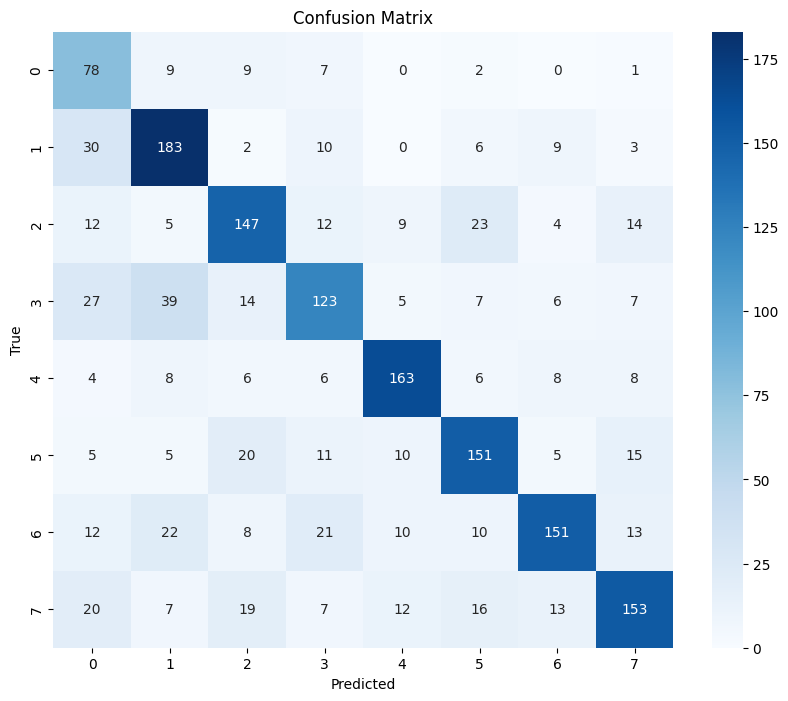

In [8]:
# Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

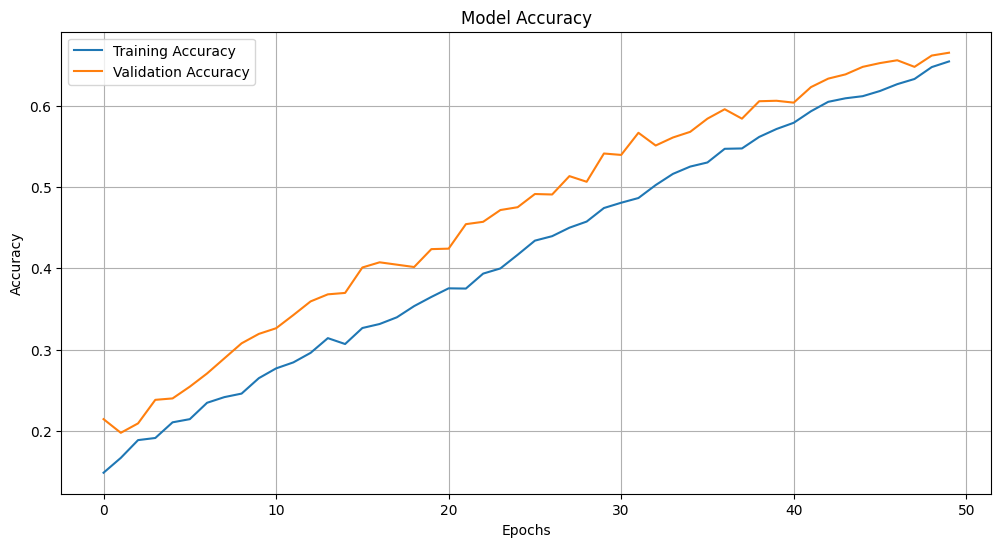

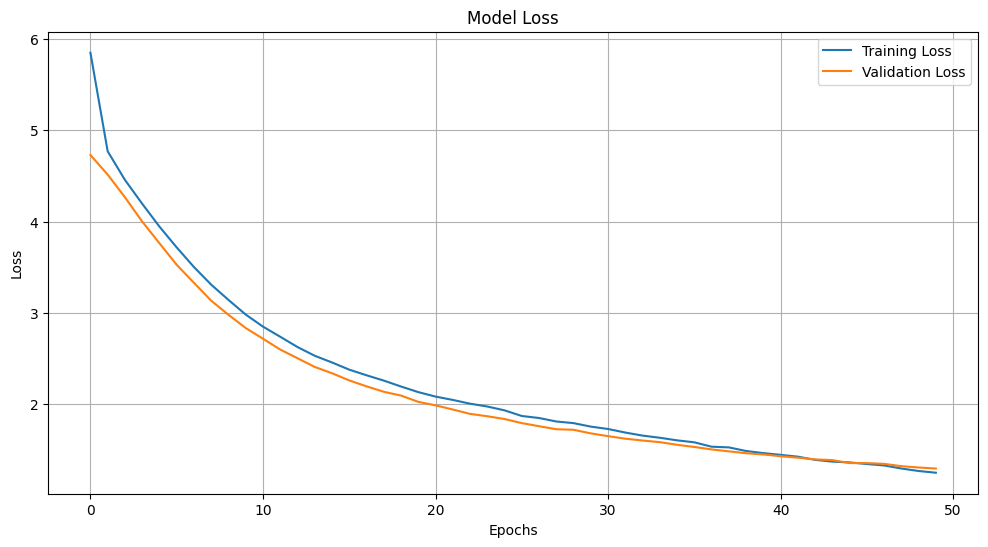

In [9]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

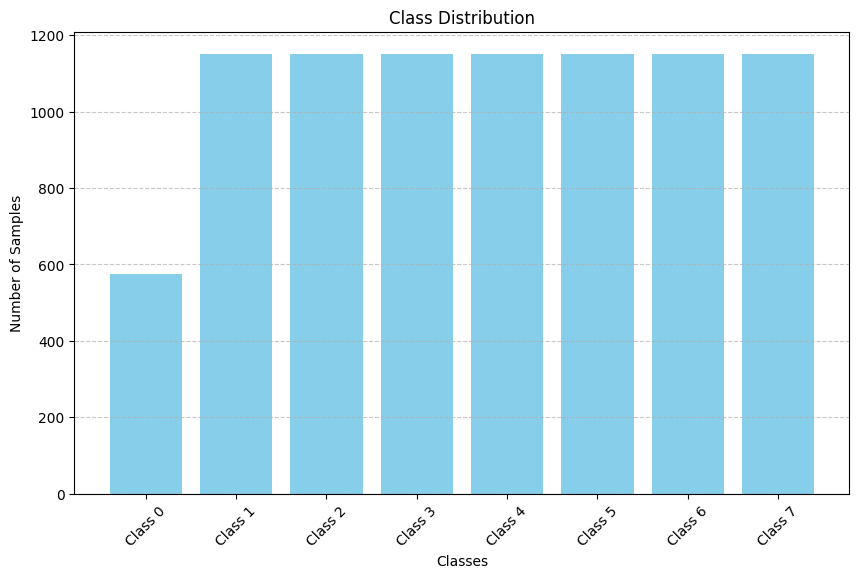

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `labels` is a NumPy array containing the class labels
def plot_class_distribution(labels, num_classes):
    class_counts = np.bincount(labels, minlength=num_classes)
    class_labels = [f"Class {i}" for i in range(num_classes)]

    # Plot the class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, class_counts, color='skyblue')
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage
num_classes = 8  # Replace with the number of classes in your dataset
plot_class_distribution(labels, num_classes)

Epoch 1/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5593 - loss: 1.2346 - val_accuracy: 0.5857 - val_loss: 1.1157 - learning_rate: 1.0000e-04
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5347 - loss: 1.2992 - val_accuracy: 0.5830 - val_loss: 1.1231 - learning_rate: 1.0000e-04
Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5506 - loss: 1.2402 - val_accuracy: 0.5884 - val_loss: 1.0978 - learning_rate: 1.0000e-04
Epoch 4/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5621 - loss: 1.2112 - val_accuracy: 0.5933 - val_loss: 1.1017 - learning_rate: 1.0000e-04
Epoch 5/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5697 - loss: 1.2062 - val_accuracy: 0.6003 - val_loss: 1.0859 - learning_rate: 1.0000e-04
Epoch 6/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5832 - loss: 1.2000 - val_accuracy: 0.6014 - val_loss: 1.0701 - learning_rate: 1.0000e-04
Epoch 7/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 

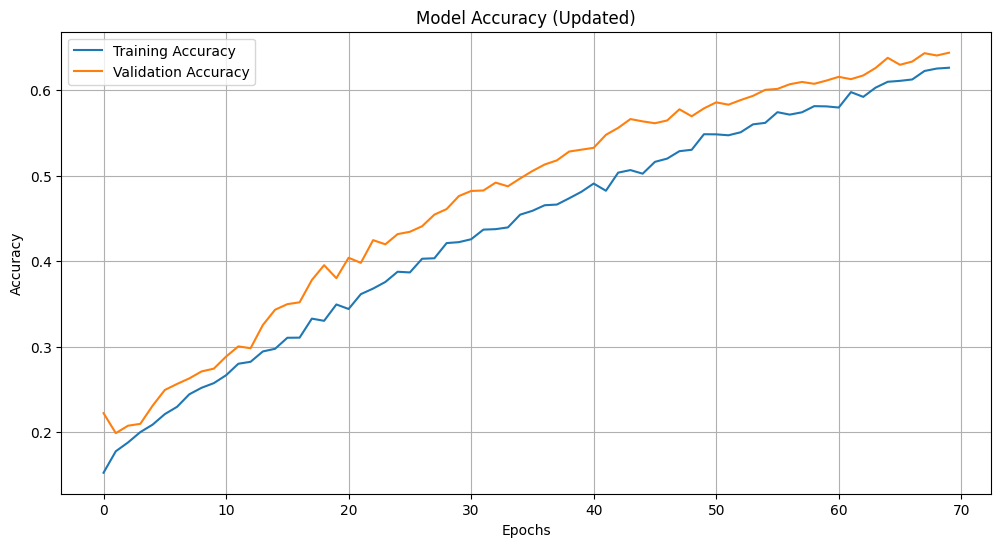

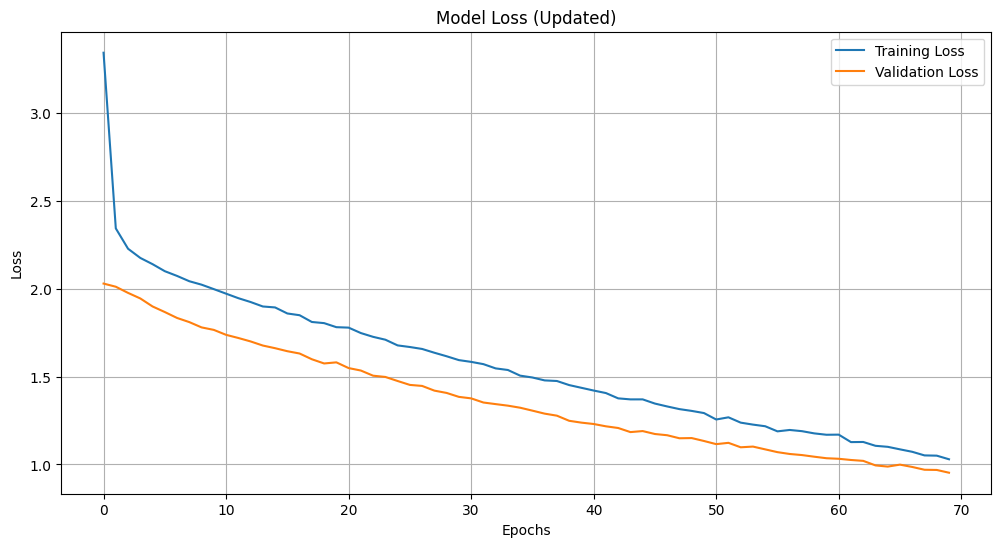

In [20]:
# Continue training the model for more epochs
additional_epochs = 20  # Specify the number of additional epochs

# Use the same callbacks as before
history_additional = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=additional_epochs,
    batch_size=32,
    class_weight=class_weights,  # Use the same class weights
    callbacks=[early_stopping, lr_scheduler]
)

# Combine the new history with the previous one
history.history['accuracy'] += history_additional.history['accuracy']
history.history['val_accuracy'] += history_additional.history['val_accuracy']
history.history['loss'] += history_additional.history['loss']
history.history['val_loss'] += history_additional.history['val_loss']

# Plot updated training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Updated)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot updated training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Updated)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6296 - loss: 1.0296 - val_accuracy: 0.6426 - val_loss: 0.9604 - learning_rate: 1.0000e-04
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6267 - loss: 1.0248 - val_accuracy: 0.6513 - val_loss: 0.9464 - learning_rate: 1.0000e-04
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6348 - loss: 1.0065 - val_accuracy: 0.6513 - val_loss: 0.9400 - learning_rate: 1.0000e-04
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6362 - loss: 1.0195 - val_accuracy: 0.6584 - val_loss: 0.9317 - learning_rate: 1.0000e-04
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6395 - loss: 1.0247 - val_accuracy: 0.6562 - val_loss: 0.9330 - learning_rate: 1.0000e-04
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6556 - loss: 0.9972 - val_accuracy: 0.6665 - val_loss: 0.9033 - learning_rate: 1.0000e-04
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 

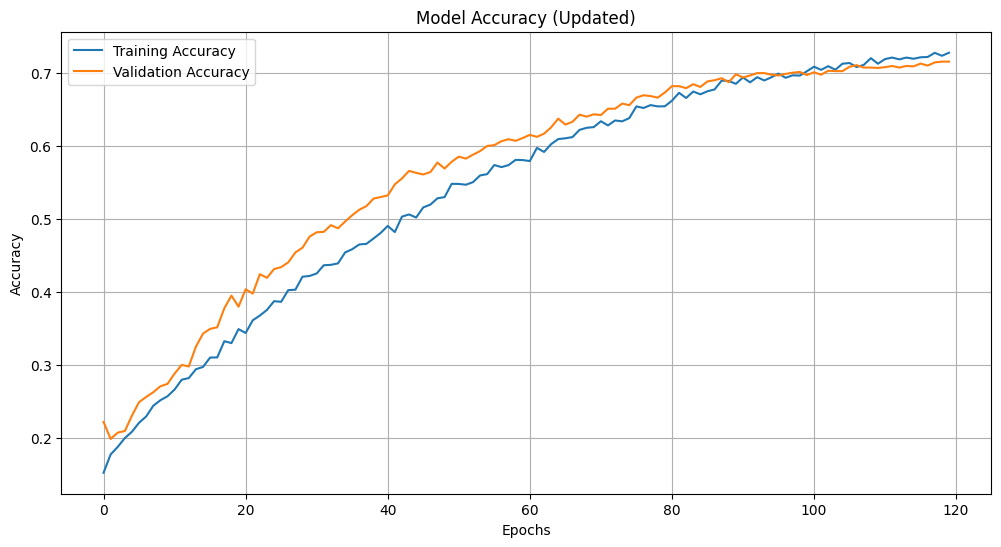

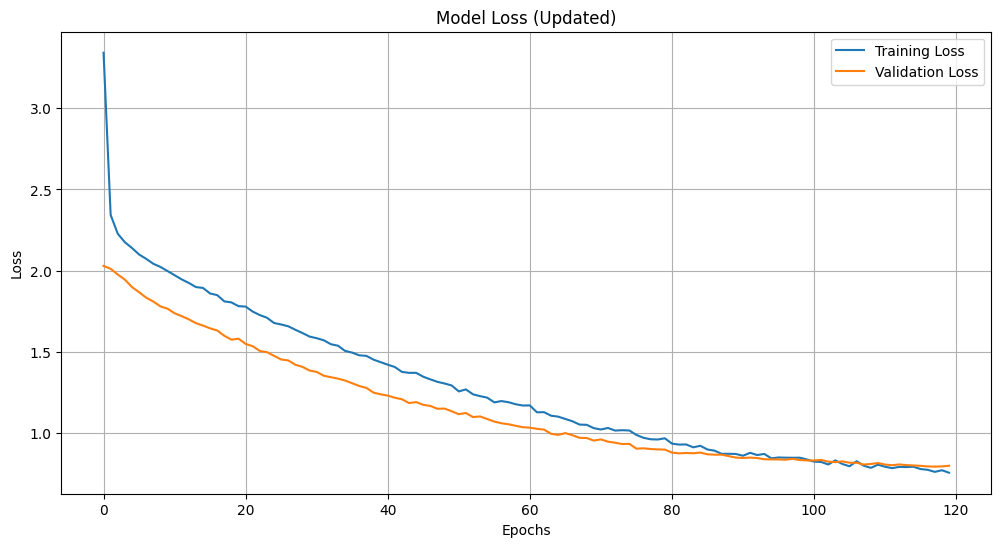

In [21]:
# Continue training the model for more epochs
additional_epochs = 50  # Specify the number of additional epochs

# Use the same callbacks as before
history_additional = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=additional_epochs,
    batch_size=32,
    class_weight=class_weights,  # Use the same class weights
    callbacks=[early_stopping, lr_scheduler]
)

# Combine the new history with the previous one
history.history['accuracy'] += history_additional.history['accuracy']
history.history['val_accuracy'] += history_additional.history['val_accuracy']
history.history['loss'] += history_additional.history['loss']
history.history['val_loss'] += history_additional.history['val_loss']

# Plot updated training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Updated)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot updated training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Updated)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Epoch 1/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7351 - loss: 0.7598 - val_accuracy: 0.7115 - val_loss: 0.7939 - learning_rate: 5.0000e-05
Epoch 2/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7260 - loss: 0.7479 - val_accuracy: 0.7148 - val_loss: 0.7919 - learning_rate: 5.0000e-05
Epoch 3/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7421 - loss: 0.7554 - val_accuracy: 0.7142 - val_loss: 0.7902 - learning_rate: 5.0000e-05
Epoch 4/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7355 - loss: 0.7367 - val_accuracy: 0.7148 - val_loss: 0.7880 - learning_rate: 5.0000e-05
Epoch 5/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7353 - loss: 0.7420 - val_accuracy: 0.7115 - val_loss: 0.7922 - learning_rate: 5.0000e-05


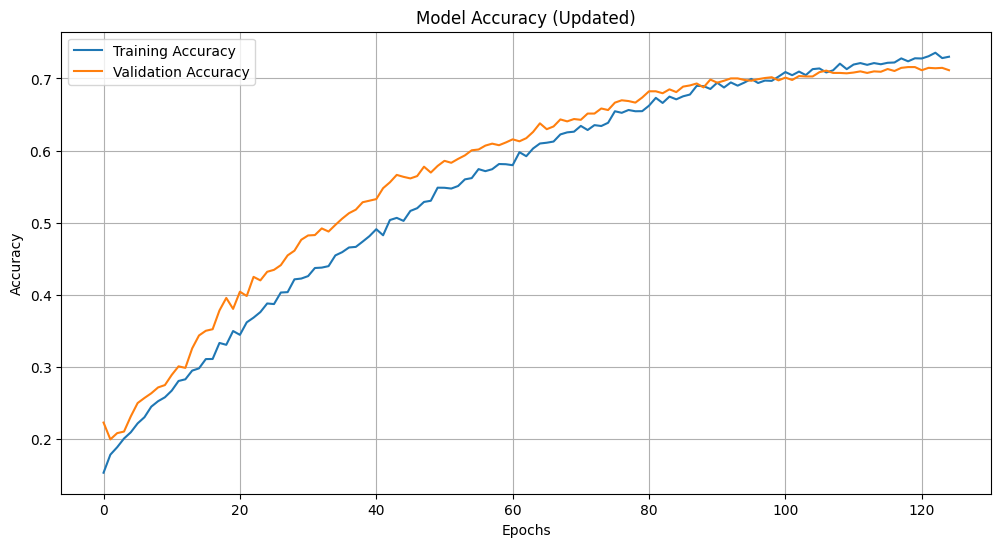

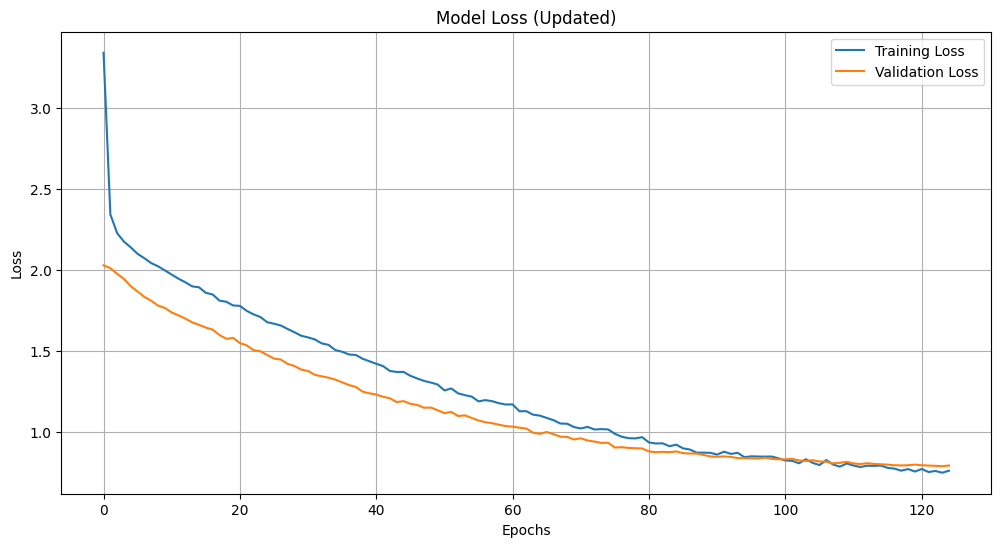

In [22]:
# Continue training the model for more epochs
additional_epochs = 5  # Specify the number of additional epochs

# Use the same callbacks as before
history_additional = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=additional_epochs,
    batch_size=32,
    class_weight=class_weights,  # Use the same class weights
    callbacks=[early_stopping, lr_scheduler]
)

# Combine the new history with the previous one
history.history['accuracy'] += history_additional.history['accuracy']
history.history['val_accuracy'] += history_additional.history['val_accuracy']
history.history['loss'] += history_additional.history['loss']
history.history['val_loss'] += history_additional.history['val_loss']

# Plot updated training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Updated)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot updated training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Updated)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Epoch 1/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7368 - loss: 0.7474 - val_accuracy: 0.7137 - val_loss: 0.7950 - learning_rate: 5.0000e-05
Epoch 2/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7207 - loss: 0.7574 - val_accuracy: 0.7115 - val_loss: 0.7957 - learning_rate: 5.0000e-05
Epoch 3/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7301 - loss: 0.7642 - val_accuracy: 0.7148 - val_loss: 0.7842 - learning_rate: 5.0000e-05
Epoch 4/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7468 - loss: 0.7266 - val_accuracy: 0.7158 - val_loss: 0.7827 - learning_rate: 5.0000e-05
Epoch 5/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7333 - loss: 0.7610 - val_accuracy: 0.7191 - val_loss: 0.7814 - learning_rate: 5.0000e-05


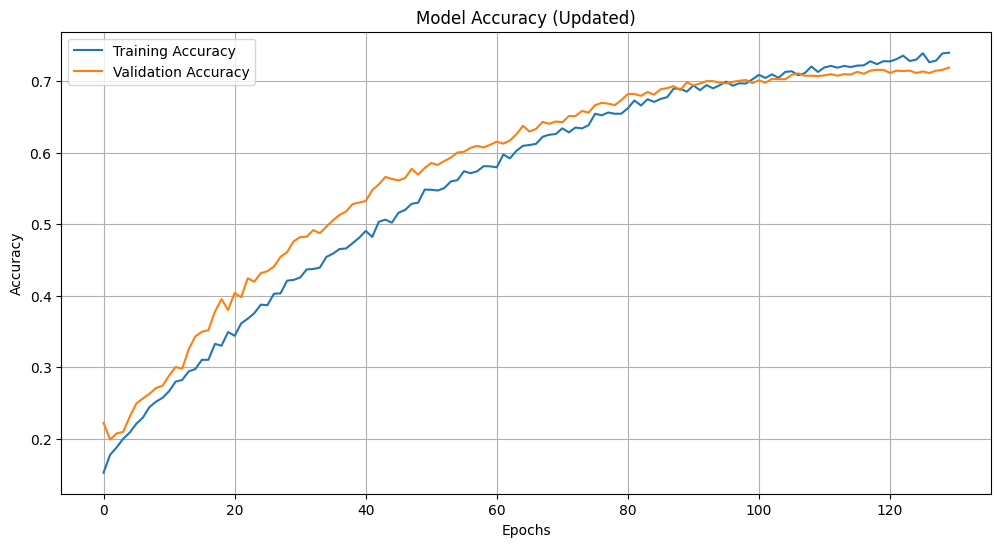

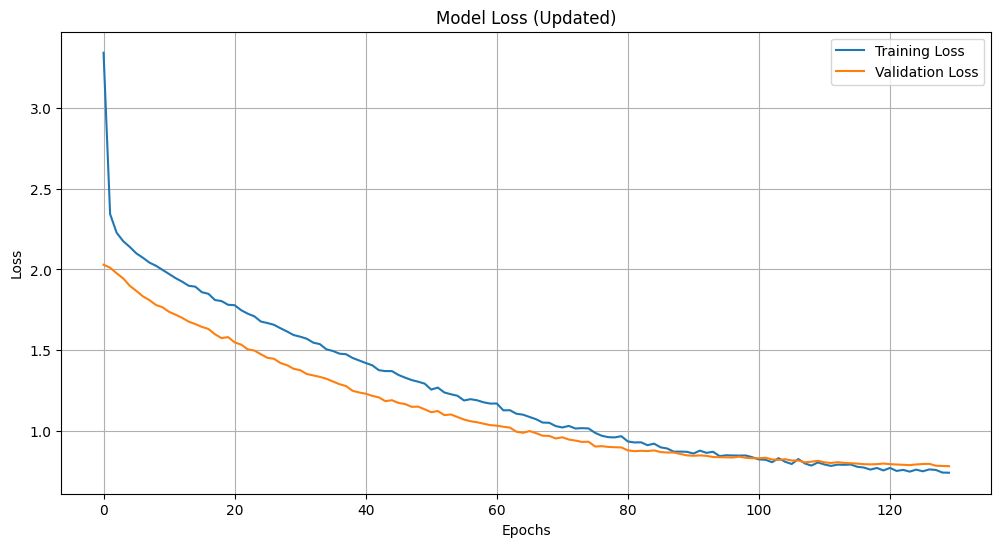

In [23]:
# Continue training the model for more epochs
additional_epochs = 5  # Specify the number of additional epochs

# Use the same callbacks as before
history_additional = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=additional_epochs,
    batch_size=32,
    class_weight=class_weights,  # Use the same class weights
    callbacks=[early_stopping, lr_scheduler]
)

# Combine the new history with the previous one
history.history['accuracy'] += history_additional.history['accuracy']
history.history['val_accuracy'] += history_additional.history['val_accuracy']
history.history['loss'] += history_additional.history['loss']
history.history['val_loss'] += history_additional.history['val_loss']

# Plot updated training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Updated)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot updated training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Updated)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Epoch 1/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7437 - loss: 0.7169 - val_accuracy: 0.7191 - val_loss: 0.7832 - learning_rate: 5.0000e-05
Epoch 2/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7355 - loss: 0.7353 - val_accuracy: 0.7158 - val_loss: 0.7793 - learning_rate: 5.0000e-05
Epoch 3/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7447 - loss: 0.7036 - val_accuracy: 0.7153 - val_loss: 0.7766 - learning_rate: 5.0000e-05
Epoch 4/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7415 - loss: 0.7345 - val_accuracy: 0.7196 - val_loss: 0.7697 - learning_rate: 5.0000e-05
Epoch 5/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7418 - loss: 0.7350 - val_accuracy: 0.7169 - val_loss: 0.7683 - learning_rate: 5.0000e-05


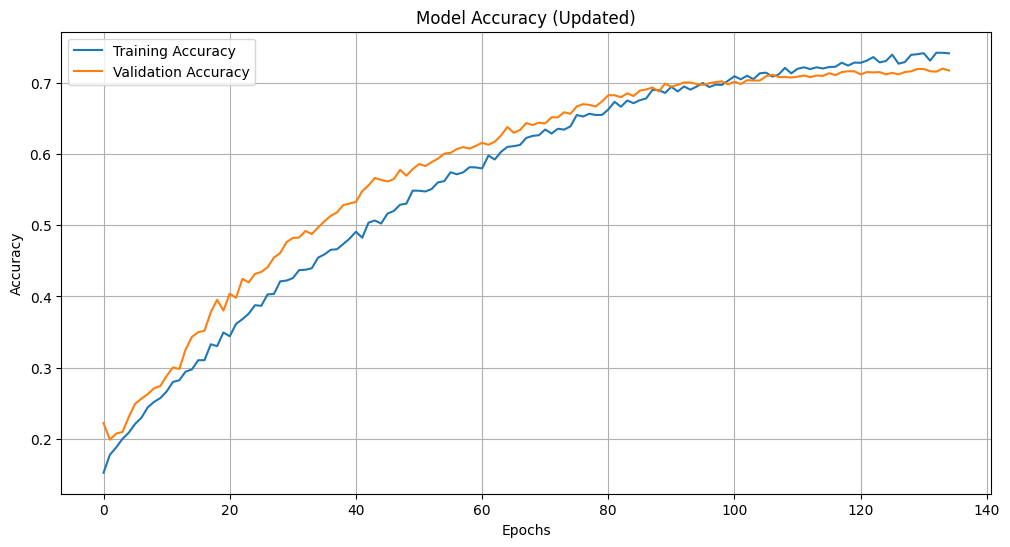

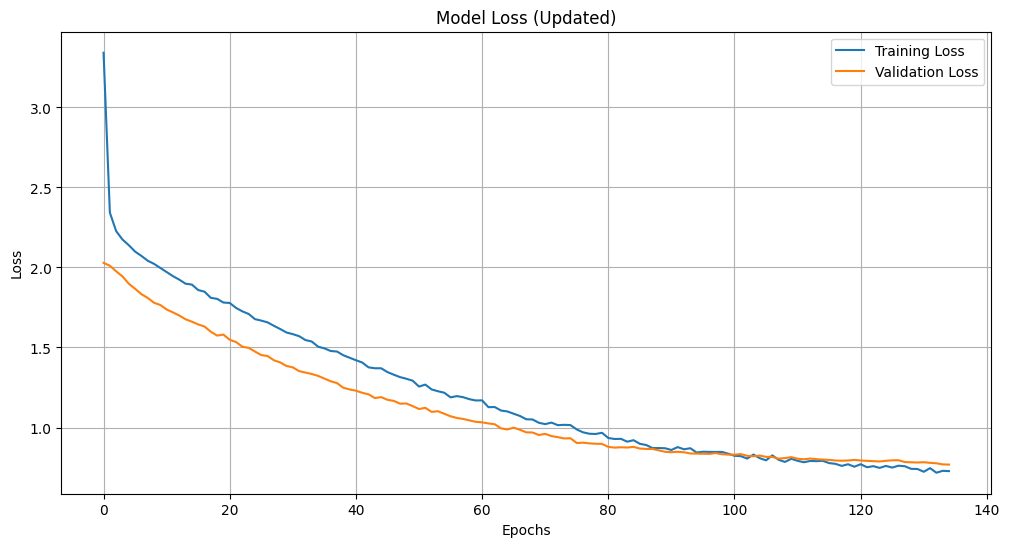

In [24]:
# Continue training the model for more epochs
additional_epochs = 5  # Specify the number of additional epochs

# Use the same callbacks as before
history_additional = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=additional_epochs,
    batch_size=32,
    class_weight=class_weights,  # Use the same class weights
    callbacks=[early_stopping, lr_scheduler]
)

# Combine the new history with the previous one
history.history['accuracy'] += history_additional.history['accuracy']
history.history['val_accuracy'] += history_additional.history['val_accuracy']
history.history['loss'] += history_additional.history['loss']
history.history['val_loss'] += history_additional.history['val_loss']

# Plot updated training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Updated)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot updated training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Updated)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7396 - loss: 0.7395 - val_accuracy: 0.7213 - val_loss: 0.7675 - learning_rate: 5.0000e-05
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7542 - loss: 0.7082 - val_accuracy: 0.7169 - val_loss: 0.7658 - learning_rate: 5.0000e-05
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7261 - loss: 0.7535 - val_accuracy: 0.7207 - val_loss: 0.7699 - learning_rate: 5.0000e-05
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7453 - loss: 0.7236 - val_accuracy: 0.7234 - val_loss: 0.7660 - learning_rate: 5.0000e-05
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7416 - loss: 0.7198 - val_accuracy: 0.7229 - val_loss: 0.7715 - learning_rate: 5.0000e-05
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7399 - loss: 0.7412 - val_accuracy: 0.7218 - val_loss: 0.7679 - learning_rate: 2.5000e-05
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 

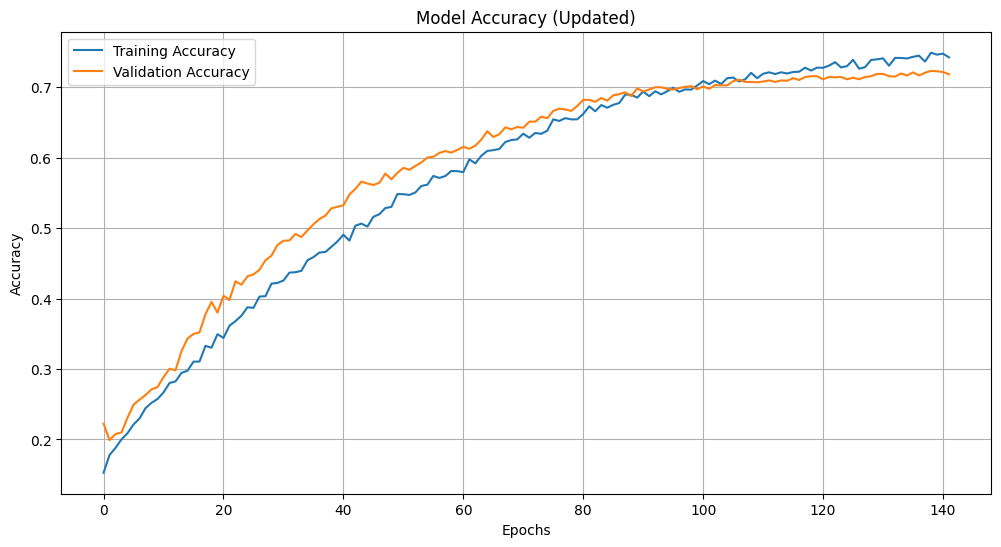

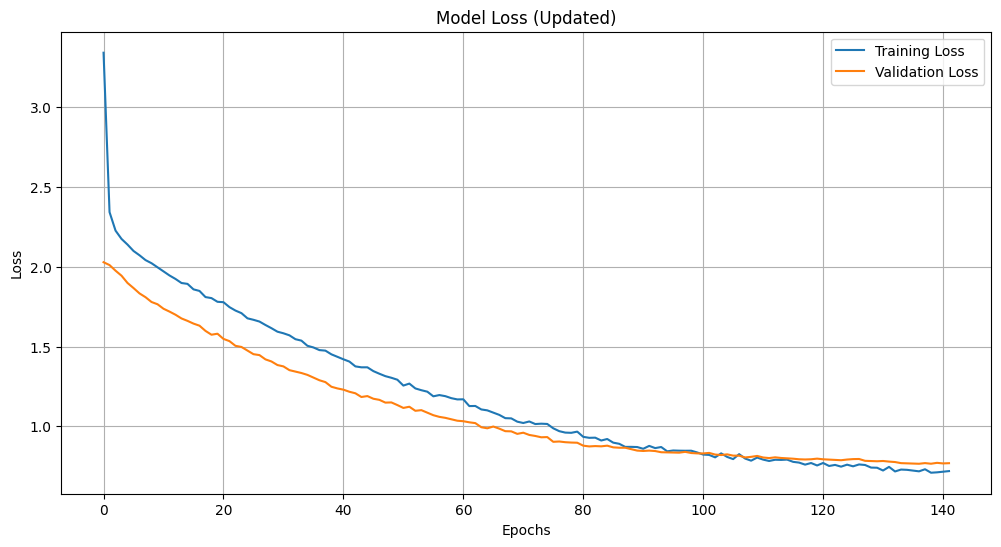

In [25]:
# Continue training the model for more epochs
additional_epochs = 10  # Specify the number of additional epochs

# Use the same callbacks as before
history_additional = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=additional_epochs,
    batch_size=32,
    class_weight=class_weights,  # Use the same class weights
    callbacks=[early_stopping, lr_scheduler]
)

# Combine the new history with the previous one
history.history['accuracy'] += history_additional.history['accuracy']
history.history['val_accuracy'] += history_additional.history['val_accuracy']
history.history['loss'] += history_additional.history['loss']
history.history['val_loss'] += history_additional.history['val_loss']

# Plot updated training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Updated)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot updated training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Updated)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


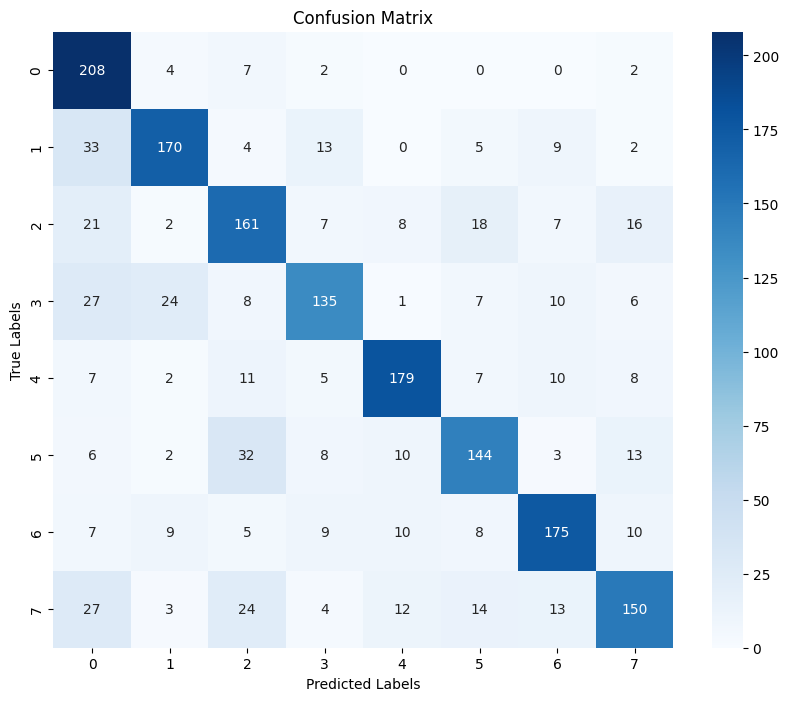

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.93      0.74       223
           1       0.79      0.72      0.75       236
           2       0.64      0.67      0.65       240
           3       0.74      0.62      0.67       218
           4       0.81      0.78      0.80       229
           5       0.71      0.66      0.68       218
           6       0.77      0.75      0.76       233
           7       0.72      0.61      0.66       247

    accuracy                           0.72      1844
   macro avg       0.73      0.72      0.72      1844
weighted avg       0.73      0.72      0.72      1844



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

In [29]:
from tensorflow.keras.models import load_model
import shutil

# Save the model to a file
model.save('emotion_detection_model.h5')  # Ensure the file name matches here

# Check if the file exists
import os
if os.path.exists('emotion_detection_model.h5'):
    # Create a zip file for downloading
    shutil.make_archive('emotion_detection_model', 'zip', '.', 'emotion_detection_model.h5')

    # Provide a link to download the model
    from IPython.display import FileLink
    display(FileLink('emotion_detection_model.zip'))
else:
    print("Model file not found. Ensure the model is saved correctly.")

/kaggle/working/emotion_detection_model.zip

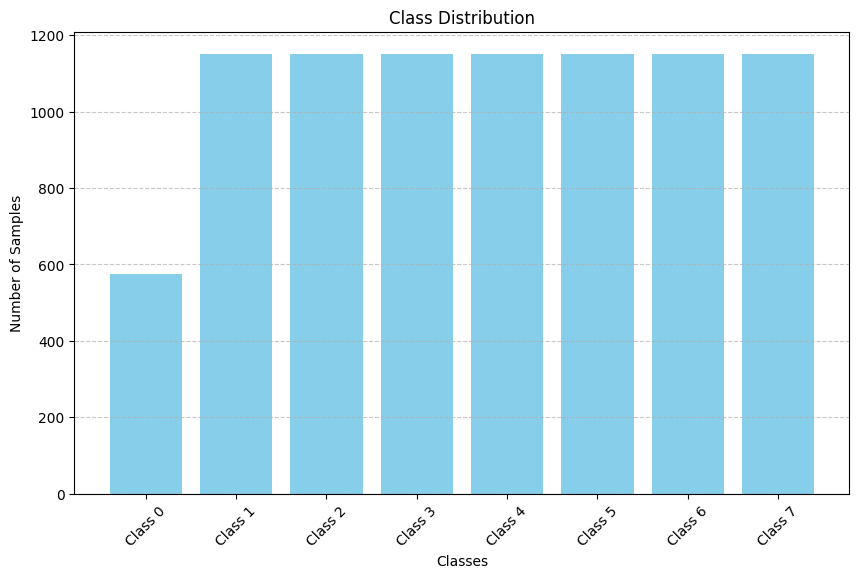

In [30]:
# Visualize class distribution
def plot_class_distribution(labels, num_classes):
    class_counts = np.bincount(labels, minlength=num_classes)
    class_labels = [f"Class {i}" for i in range(num_classes)]

    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, class_counts, color='skyblue')
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage
num_classes = 8  # Replace with the number of classes in your dataset
plot_class_distribution(labels, num_classes)

In [32]:
# Extract confusion matrix rows for Classes 3 and 7
conf_matrix_class_3 = conf_matrix[3]
conf_matrix_class_7 = conf_matrix[7]

# Print confusion details
print("Confusion for Class 3:")
for i, count in enumerate(conf_matrix_class_3):
    print(f"Predicted as Class {i}: {count} samples")

print("\nConfusion for Class 7:")
for i, count in enumerate(conf_matrix_class_7):
    print(f"Predicted as Class {i}: {count} samples")

Confusion for Class 3:
Predicted as Class 0: 27 samples
Predicted as Class 1: 24 samples
Predicted as Class 2: 8 samples
Predicted as Class 3: 135 samples
Predicted as Class 4: 1 samples
Predicted as Class 5: 7 samples
Predicted as Class 6: 10 samples
Predicted as Class 7: 6 samples

Confusion for Class 7:
Predicted as Class 0: 27 samples
Predicted as Class 1: 3 samples
Predicted as Class 2: 24 samples
Predicted as Class 3: 4 samples
Predicted as Class 4: 12 samples
Predicted as Class 5: 14 samples
Predicted as Class 6: 13 samples
Predicted as Class 7: 150 samples
